In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import itertools
import random
import math

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [4]:
from typing import Union, List, Tuple

In [5]:
from sympy import symbols, sympify

# Index

This second notebook covers the following intermediate Graph Theory topics:

1. [Multigraphs](#Multigraphs)\
   1.1 [An applications of Multigraph in Social Network analysis](#An-applications-of-Multigraph-in-Social-Network-analysis)
2. [Coloring Theory](#Coloring-Theory)\
   2.1 [The Brooks Theorems](#The-Brooks-Theorems)\
   2.2 [The chromatic polynomial](#The-chromatic-polynomial)
3. [Introduction to Algebraic Graph Theory: the Adjacency Matrix](#Introduction-to-Algebraic-Graph-Theory:-the-Adjacency-Matrix)\
   3.1 [The spectrum of a graph](#The-spectrum-of-a-graph)

In [6]:
def plot_multigraph(G: nx.MultiGraph(), type_curvature, figsize=(4, 4), **node_args):
    '''
    Function to visualize a NetWorkx Graph

    Args:
        G (nx.Graph): a Networkx Graph
        kwargs (optional keyword arguments): additional arguments to customize the visualization

    Returns:
        The graph visualization
    '''
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_title("Graph Visual", fontsize=12)

    pos = nx.spring_layout(G)
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, **node_args)
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight="bold")
    
    # Draw distinct edges with different curvature
    for (u, v, data) in G.edges(data=True):
        edge_type = data["type"]
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            width=2, alpha=0.7, 
            connectionstyle=f"arc3,rad={type_curvature[edge_type]}"
        )

    # Add edge labels
    edge_labels = {(u, v): d["type"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
    

    plt.show()

In [7]:
def plot_simple_graph(G: nx.Graph, **kwargs):
    '''
    Function to visualize a NetWorkx Graph

    Args:
        G (nx.Graph): a Networkx simple Graph
        kwargs (optional keyword arguments): additional arguments to customize the visualization

    Returns:
        The graph visualization
    '''
    fig, ax = plt.subplots(figsize=(4, 4))

    ax.set_title("Graph Visual", fontsize=12)
    nx.draw_networkx(G, **kwargs)

# Intermediate concepts in Graph Theory: from *Multigraphs* to *Bipartite Graphs*

In the first notebook, we covered the basics of Graph Theory, introducing concepts such as simple graphs and exploring fundamental theorems regarding their structure and topology. Additionally, we demonstrated how to work with simple graphs in Python using the `networkx` package. In this notebook, we will delve deeper into the subject by discussing more advanced topics, including *multigraphs* and the so-called coloring theory. Furthermore, we will explore different graph representations, such as *adjacency matrices*, which enable the application of important results from linear algebra to graphs. Finally, we will examine *bipartite graphs*, a special class of graphs that naturally arise in various fields, from social networks to solid-state physics.

## Multigraphs

**Definition**: Let $V$ be a set. Then we define $P_{1,2}(V)$ the set of all 1-element or 2-element subsets of $V$, i.e.:
$$
P_{1,2}(V) = \{ S \subseteq V | |S| = {1, 2} \}  = \{ \{ u, v\} | u, v \in V \} \ \text{not necessarily distinct}
$$
For example, $P_{1, 2}(1, 2, 3) = \{ \{1\}, \{2\}, \{3\}, \{1, 2\}, \{2, 3\}, \{1, 3\}\}$. 

**Definition**: A **multigraph** is defined as $G=(E, V, \varphi)$ a set of three elements: $E$ is the **edge set**, $V$ is the **vertices set** and $\varphi$ is a map defined as $\varphi: E \rightarrow P_{1,2}(V)$.

Roughly speaking, we may say that a *multigraph* is a graph where two vertices can be connected by more than one edge (distinct elements of $P_{1, 2}(V)$ of dimension 2) and one edge can connect a node with itself (elements of dimension 1 in $P_{1,2}(V)$. Let us show how to define a multigraph in `networkx`:

In [8]:
# using the MultiGraph class
G = nx.MultiGraph()

In [9]:
nodes = [1, 2, 3, 4]
edges = [(1, 2, "A"), (1, 1, "A"), (2, 3, "A"), (2, 3, "B"), (3, 4, "A")]

In [10]:
G.add_nodes_from(nodes)
G.add_edges_from((u, v, {"type": label}) for u, v, label in edges)

[0, 0, 0, 1, 0]

Notice that we have introduced an additional parameter when defining edges, namely `type`, which in the above example can be "A" or "B":

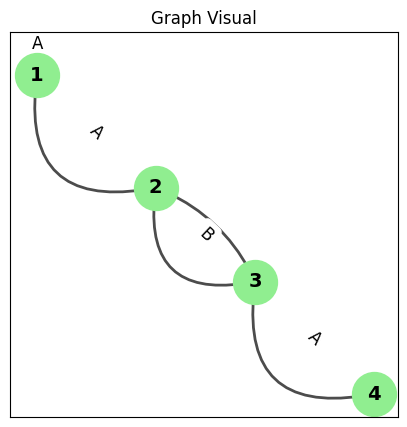

In [11]:
plot_multigraph(
    G, 
    type_curvature={"A": .7, "B": -0.2},
    figsize=(5,5),
    node_color="lightgreen",
    node_size=1000
)

All the definitions given for simple graphs still hold for multigraph. In particular, the **degree** $\deg(v)$ of a vertex $v \in V$ in a multigraph is the number of edges that contain $v$, where loops are counted twice:
$$
\deg v := | \{e \in E | v \in \varphi(e)\}| + | \{ e \in E | \varphi(E) = \{ v\} \}|
$$
Notice that, unlike for simple graphs, in multigraphs the degree of a node is not the number of **neigbors** of $v$, unless $v$ is not contained in any loops or in **parallel edges**. Parallel edges are two edges connecting the same nodes. For example, in the above graphs:

In [12]:
# The degree of 1 is 3: 1 loop plus a single edge
G.degree(1)

3

In [13]:
len(list(G.neighbors(1)))

2

Also the notions of **walks** and **paths** can be still applied to multigraph. Let us introduce a special class of paths that we missed in the first notebook, namely

**Definition**: Let $G=(V, E)$ a simple graph. An **Hamiltonian path** in $G$ is a walk of $G$ that contains each vertex of $G$ exactly once, i.e. it is a path.

**Defintion**: Let $G=(V, E)$ a simple graph. An **Hamiltonian cycle** in $G$ is a cycle $(v_0, v_1, ..., v_{k})$ of $G$ such that each vertex of $G$ appears exactly once among $v_0, v_1, ..., v_{k-1}$.

These definitions apply as well for multigraphs. Of course, not all graphs have Hamiltonian paths. However, if a graph has an Hamiltonian cycle then it as an Hamiltonian path, obtained by removing the last vertex. Finding an Hamiltonian path or an Hamiltonian cycle or prove that none exists is known as the **"Hamiltonian path problem**. It is an hard known problem in the computer science literature because it is an NP-hard problem: it can be solved with a brute-force approach but no polynomial-time algorithms are known. Some fastest algorithms exist but the best are at most with a complexity of $O(n^22^n)$. Below, an example of a graph with an Hamiltonian path:

In [14]:
G_hamp = nx.MultiGraph()

hamp_nodes = [1, 2, 3, 4, 5]
hamp_edges = [(1, 2, "A"), (2, 3, "A"), (3, 4, "A"), (4, 5, "A"), (5, 1, "B"), (2, 4, "C"), (2, 3, "B")]

G_hamp.add_nodes_from(nodes)
G_hamp.add_edges_from((u, v, {"type": label}) for u, v, label in hamp_edges)

[0, 0, 0, 0, 0, 0, 1]

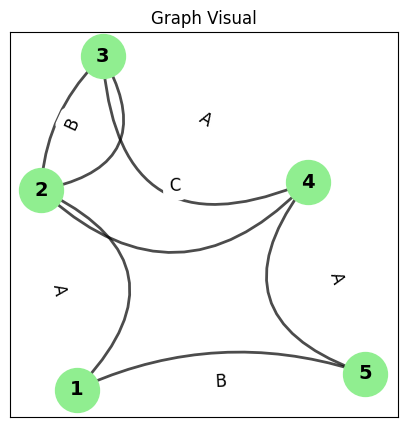

In [15]:
plot_multigraph(
    G_hamp, 
    type_curvature={"A": .7, "B": -0.2, "C": 0.5},
    figsize=(5,5),
    node_color="lightgreen",
    node_size=1000
)

The Hamiltonian path in the above example is the path defined by the vertices: $ 1 \rightarrow 2 \rightarrow 3 \rightarrow 4 \rightarrow 5$.

In part 1, we have discussed and proved one of the most important theorem in graph theory, the **Euler's theorem**. Such theorem can be stated as well for multigraphs:

**Theorem (Euler, 1736)**: Let $G=(V, E, \varphi)$ be a multigraph. Then:
$$
\sum_{v \in V(G)} \deg(v) = 2\cdot |E(G)|
$$
*Proof.* For each edge $e$, let us denote $\alpha(e)$ and $\beta(e)$ its endpoints. If $e$ is a loop, then $\alpha(e)=\beta(e)$. By definition of degree for multigraphs we have
$$
\deg(v) = \sum_{e \in E | v = \alpha(e)} 1 + \sum_{e \in E | v = \beta(e)}1
$$
notice that for a loop, the edge is counted twice, because $v$ is both $\alpha(e)$ and $\beta(e)$. Summing over all v:
$$
\begin{align}
\deg(v) &= \sum_{v\in V} \sum_{e \in E | v = \alpha(e)} 1 + \sum_{v\in V}\sum_{e \in E | v = \beta(e)} 1 \\
&= |E|+|E| = 2 |E|
\end{align}
$$
Indeed, if for each $v$ we sum the number of edges, we simply get the total number of edges. Therefore the theorem is proved. 

The definition of **graph isomorphism** is instead different for multigraphs, and a single bijective map between vertex of two graphs is not sufficient to define whether they are isomorphic or not. 

**Definition**: Let $G=(V, E, \varphi)$ and $H=(W, F, \psi)$ be two multigraphs. A **graph isomorphism** between $G$ and $H$ is a pair of bijective relations $(\phi_1, \phi_2)$:
$$
\begin{gather}
\phi_1: V \rightarrow W \\
\phi_2: E \rightarrow F
\end{gather}
$$
such that if $e \in E$, with endpoints $(v_1, v_2)$, then the endpoints of $\phi_2(e)$, say $w_1, w_2$, are the images under $\phi_1$ of the endpoints of $e$, i.e. $\phi_1(v_1) = w_1$.

### An applications of Multigraph in Social Network analysis

As you may have understood, multigraphs can be used in many real-life scenarios where relationships between entities are not straightforward and can be of multiple type. A common example is that of **social networks**, where edges can be used to represent "interactions" between persons and thus a multigraph can capture the variety of interactions that social network enables. Let us make a practical example, considering the following multigraph:

In [16]:
G_sn = nx.MultiGraph()

In [17]:
person_nodes = ["Alice", "Bob", "Hilbert", "Laplace", "Marie"]
interaction_edges = [("Alice", "Bob", 5, "DM"), 
                     ("Alice", "Bob", 2, "Comment"),
                     ("Bob", "Hilbert", 3, "DM"),
                     ("Hilbert", "Marie", 6, "Comment"),
                     ("Laplace", "Marie", 4, "Comment")
                    ]

In [18]:
G_sn.add_nodes_from(person_nodes)
G_sn.add_edges_from((u, v, weight, {"type": label, "weight": weight}) for u, v, weight, label in interaction_edges)

[5, 2, 3, 6, 4]

We have a multigraph representing a social network where people can interact in two ways: via "DM", i.e. *direct messages*, or with "Comment", i.e. *leaving* comment on friend's post. The multigraph is also "weighted" in the sense that we have assigned a number to each edge, indicating the number of interactions. Let's visualize the multigraph (we are using a drawing function provided by the `NetworkX` docs: look at the following link [Plotting Multigraph](https://networkx.org/documentation/stable/auto_examples/drawing/plot_multigraphs.html))

In [19]:
def draw_labeled_multigraph(G, attr_name, weight_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in itertools.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="lightblue", ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        G, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attrs[attr_name]}|{weight_name}={attrs[weight_name]}"
        for *edge, attrs in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.5,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )

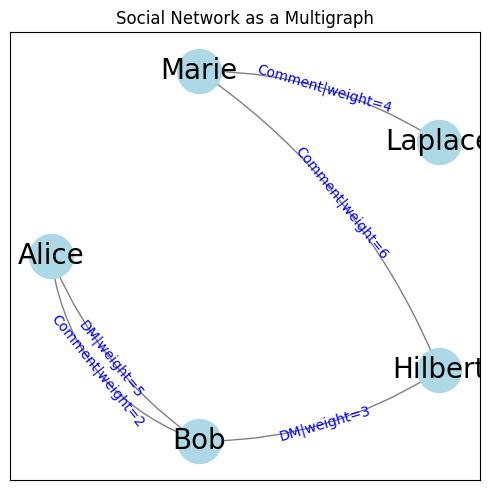

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
draw_labeled_multigraph(G_sn, "type", "weight", ax)
ax.set_title("Social Network as a Multigraph")
fig.tight_layout()
plt.show()

Of course, treating social network theory is beyond the scope of this notebook. Here, we are just giving an example of the application of multigraphs and show their capabilities to model such kind of problems. For instance, some simple analysis we could perform on such a graph may be the following:
- *finding the strongest communication channels*;
- *identifying persons mostly interacting with each other*

In [21]:
# Identifying persons with the highest interactions
sum_person_nteractions = {}
for person in G_sn.nodes():
    sum_person_nteractions[person] = sum(data["weight"] for i, v, data in G_sn.edges(data=True) if person in (i, v))

In [22]:
sum_person_nteractions

{'Alice': 7, 'Bob': 10, 'Hilbert': 9, 'Laplace': 4, 'Marie': 10}

In the above example, Bob has the highest interaction score (considered as the sum of interaction weights). As for the most used communication channels:

In [23]:
sum_interactions = {"DM": 0, "Comment": 0}
for u, v, data in G_sn.edges(data=True):
    type = data["type"]
    sum_interactions[type] += data["weight"]

In [24]:
sum_interactions

{'DM': 8, 'Comment': 12}

The "Comment" communication channel has insted the highest summed weights. 

Since we are talking about social network theory, let us now prove an interesting result in graph theory which leads to a curious features of social networks. Let $G=(V, E, \varphi)$ a multigraph with no loop and let $e \in E$ an edge of $G$. Let us assume that $v$ is an endpoint of $e$ and we denote as $e/v$ the endpoint of $e$ distinct from $v$. For each $v$ we define the following rational number $q_v$:
$$
q_v = \sum_{e \in E, v \in \varphi(E)} \frac{\deg(e/v)}{\deg(v)}
$$
Thus, $q_v$ is the *average degree of the neighbors of $v$*, weighted by the number of edges that join $v$ to its neighbors. We can prove that

<div style="text-align: center; border: 2px solid black; background-color: #D3D3D3; padding: 10px; display: inline-block; margin: auto;">
$$
\sum_{v\in V} q_v \geq \sum_{v \in V} \deg(v)
$$
</div>

In other words, *your average friend in a social network has, on average, more friends than you do!*. From the Euler's theorem, the above result can be restated as:
$$
\sum_{v\in V} q_v \geq 2|E|
$$
Summing over $v$ the expression of $q_v$ we get:
$$
\sum_v \sum_{e \in E, v \in \varphi(E)} \frac{\deg(e/v)}{\deg(v)} =  |E| \left( \frac{\deg(e/v)}{\deg(v)} + \frac{\deg(v)}{\deg(e/v} \right)
$$
Indeed, when summing over all nodes, for each edge, each endpoint will be once the first node and then the neighbor, thus the double sum is equivalent to multiply the expression in parenthesis by the number of edges in the graph. Now, consisder the following expression:
$$
(x-y)^2 \geq 0
$$
which is positive for any real positive number $x, y > 0 $. Therefore, 
$$
(x-y)^2 = x^2+y^2 - 2xy \geq 0 \Longrightarrow x^2+y^2 \geq 2xy
$$
Dividing by $xy$ both side (since $xy>0$):
$$
\frac{x^2}{xy}+\frac{y^2}{xy} = \frac{x}{y} + \frac{y}{x} \geq 2
$$
In the equation for $q_v$ we can recognize the expression given by the above inequality, therefore we by substitution:
$$
\sum_{v\in V} q_v = |E| \left( \frac{\deg(e/v)}{\deg(v)} + \frac{\deg(v)}{\deg(e/v} \right) \geq |E|\cdot 2 
$$
and thus the result is proved.

## Coloring Theory

In graph theory, **coloring** means *assigning labels - in general positive integers - to each vertex of a graph*. Such positive integers are 
called **colors**. Rougly speaking, we could say that coloring a graph is a way to "partition" its nodes into different groups, where each group is defined by a given color. Graph coloring theory has numerous applications in many fields. Some examples include:

- *scheduling problems*: coloring theory is often used to schedule jobs avoiding possible conflicts, and therefore to assign efficiently jobs to proper time slots. In this scenario, different jobs are nodes of a graph, edges between two jobs denote jobs sharing some resources. The objective is to color each node so that no pair of jobs share the same color (color are the available time slots). An example of this kind of problems is that of assigning aircraft to flights;
- *map coloring*: another possible application is that of "map coloring", i.e. the assignment of colors to regions in a map, ensuring that no adjacent regions share the same color;
- *networks*: graph coloring is ofted used in network communications, e.g. for assigning frequencies to devices such that there no adjacent devices using the same frequency.

Let us now give a rigorous mathematical definition of coloring:

**Definition**: Let $G=(V, E, \varphi)$ a multigraph and $k \in \mathcal{N}$. Then:
- A **$k$-coloring** of $G$ is a map $f : V \rightarrow \{ 1, 2, ..., k\}$. The integer numbers $1, 2, ..., k$ are called **colors** and given $v \in V$, $f(v)$ is corresponding color of $v$;
- A $k$-coloring of $G$ is said to be **proper** if no adjacent nodes of $G$ share the same color, i.e. $\nexists e \in E | f(u) = f(v), uv = e$.

For example, let us consider the Petersen graph (below we represent it in its classic layout):

In [25]:
# Build the Petersen graph
g_petersen = nx.petersen_graph()

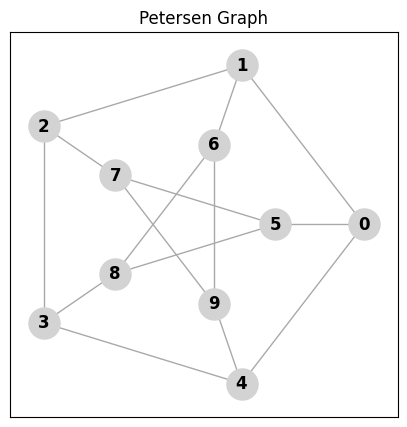

In [26]:
# Define fixed positions for a "nice" layout
positions = {}

# Outer pentagon nodes
for i in range(5):
    angle = 2 * np.pi * i / 5
    positions[i] = (np.cos(angle), np.sin(angle))

# Inner pentagram nodes
for i in range(5, 10):
    angle = 2 * np.pi * (i - 5) / 5 
    positions[i] = (0.5 * np.cos(angle), 0.5 * np.sin(angle))

# Draw the graph
plt.figure(figsize=(5, 5))
nx.draw_networkx(
    g_petersen, pos=positions, with_labels=True,
    node_size=500, node_color="lightgrey", font_size=12,
    font_weight='bold', edge_color='darkgrey'
)
plt.title("Petersen Graph")
plt.show()

This graph has a **3-proper coloring**, given by the following map:
$$
f: \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\} \rightarrow \{1, 2, 1, 2, 3, 2, 1, 3, 3, 1\}
$$

Indeed, using the following color map: 1 -> "blue", 2 -> "red", 3 -> "green":

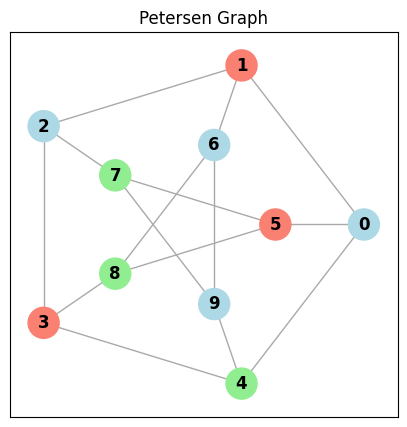

In [27]:
# Draw the graph -> we use light colors for a better visualization
color_map = { 1: "lightblue", 2: "salmon", 3: "lightgreen"}
three_coloring = [1, 2, 1, 2, 3, 2, 1, 3, 3, 1]
node_colors = [color_map[i] for i in three_coloring]


plt.figure(figsize=(5, 5))
nx.draw_networkx(
    g_petersen, pos=positions, with_labels=True,
    node_size=500, node_color=node_colors, font_size=12,
    font_weight='bold', edge_color='darkgrey'
)
plt.title("Petersen Graph")
plt.show()

As we can see, with the above defined coloring map, there are no adjacent nodes sharing the same color. In addition, we were able to properly color the graph with just three colors. Let us make another interesting example. Given $P_n$ and $P_m$ the $n$-th and $m$-th path graph respectively, we consider the Cartesian product $P_n \times P_m$, known as the **$(n, m)$-grid graph**. Such graph has 2-proper coloring map given by:
$$
(i, j) \rightarrow \begin{cases}
1 \ \text{if} \ i+j = 2n \\
2 \ \text{if} \ i+j = 2n+1 
\end{cases}
$$
with $n \in \mathbb{N}$. For instance, let us consider the following $(2, 3)$-grid graph:

In [28]:
gg_dims = (2, 3)
gg = nx.grid_graph(dim=gg_dims)

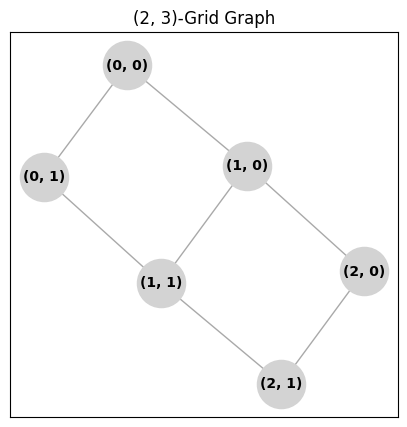

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(gg, with_labels=True, node_size=1200, node_color="lightgrey", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"{str(gg_dims)}-Grid Graph")
plt.show()

Let us apply the color map defined above:

In [30]:
node_colors = []
for v in gg.nodes:
    # check if i+j is even
    if (v[0] + v[1]) % 2 == 0:
        node_colors.append("lightblue")
    # if odd, append another color
    else:
        node_colors.append("salmon")

In [31]:
node_colors

['lightblue', 'salmon', 'salmon', 'lightblue', 'lightblue', 'salmon']

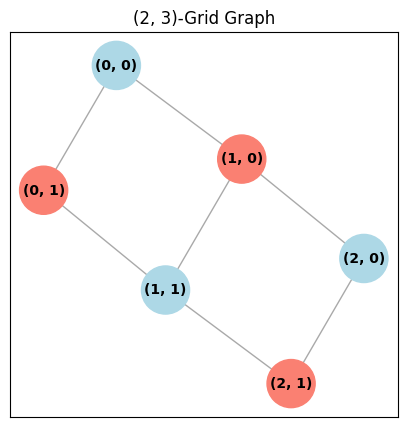

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(gg, with_labels=True, node_size=1200, node_color=node_colors, font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"{str(gg_dims)}-Grid Graph")
plt.show()

Such coloring is also known as the **chessboard coloring**, since it is the same coloring scheme used in chessboards. 

**Definition**: Let $G=(V, E, \varphi)$ a multigraph. The smallest number of colors, $\chi(G)$, needed to proper coloring a graph is called the **chromatic number** of $G$. 

With the above examples, we were able to easily find a proper coloring and map - and the corresponding chromatic number - by  a direct inspection of nodes and graph connectivity. For instance, it's clear that the chromatic number of the $(n, m)$-grid graph is 2. However, in general terms, finding a proper k-coloring is a hard computational problem, unless $k \leq 2$. However, there exist at least some sufficient criteria to establish whether a graph can have or not a proper coloring. One of the most important is the so-callled **Brooks Theorem**, for which there exist two versions discussed in the following section.

###  The Brooks Theorems

**Theorem( Little Brooks Theorem)**: Let $G=(V, E, \varphi)$ a loopless *complete* multigraph with at least one vertex and let $\alpha$ be the maximum degree of $G$. Then, the chromatic number of $G$ is $(\alpha + 1)$. 

We remind that a *complete graph*, generally denoted as $K_n$ is a graph in which each pair of distinct vertices is connected by an edge. Therefore, by definition a complete graph $K_n$ with $n$ nodes has maximum degree of $n-1$. 

Let's test empirically this theorem applying a Depth-First Search algorithm approach. Basically, we can do the following:
1. We generate a list of possibile $\alpha+1$ colors where $\alpha$ is the max degree of the graph;
2. We start traversing the graph with DFS. We start from a given node, say the first, and assign a color (at first we can simply assign an integer number starting from 0, since Python use zero-indexing). The color must be different from each color assigned to the node neighbors, therefore we need to keep track of forbidden colors;
3. We iterate over each node, thus exploring the whole graph

In [33]:
# A function to generate N random colors:
def generate_random_colors(N):
    '''
    Function to generate random HEX colors
    '''
    return [mcolors.to_hex((random.random(), random.random(), random.random())) for i in range(N)]

In [34]:
# Example graph
lbt_graph = nx.complete_graph(5)

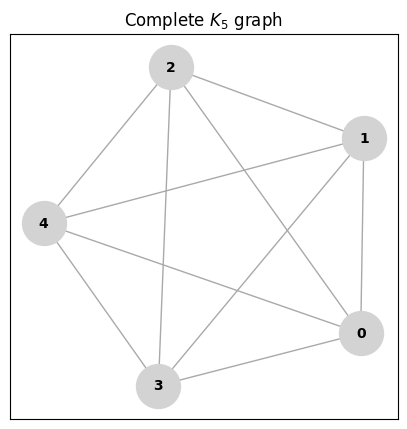

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(lbt_graph, with_labels=True, node_size=1000, node_color="lightgrey", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(fr"Complete $K_5$ graph")
plt.show()

In [36]:
# Getting the max degree
max_deg = max([lbt_graph.degree(v) for v in lbt_graph.nodes()])
print(f"The maximum degree of the given graph is: {max_deg}")

The maximum degree of the given graph is: 4


In [37]:
# Generate a number of colors equal to max_deg+1
available_colors = generate_random_colors(max_deg+1)
print(f"The number of available colors is {max_deg} + 1 =  {len(available_colors)}")

The number of available colors is 4 + 1 =  5


In [38]:
def greedy_coloring(G: nx.MultiGraph, all_colors: list) -> dict:
    '''
    Function that use a DFS approach to proper coloring a given graph

    Args:
        G (nx.MultiGraph) : a NetworkX MultiGraph
        all_colors (list(str)): a list of colors

    Returns:
        (dict) : A dictionary mapping each node to a given color
    '''

    # Color assignment is the mapping node -> color (integer number), we initialize them to -1 
    color_assignment = {node: -1 for node in G.nodes() }
    
    # We create two empty set: one to store visited nodes and the other to store forbidden colors
    visited_nodes = set()
    forbidden_colors = set()

    # We define an inner recursive DFS function
    def DFS(v):
        # We add the given nodd to visited node
        visited_nodes.add(v)

        # Cycle over v neighbors and update forbidden colors
        for neighbor in G.neighbors(v):
            if color_assignment[neighbor] != -1:
                forbidden_colors.add(color_assignment[neighbor])
    

        # Now we assign the first available color
        for color in range(len(G.nodes())):
            if color not in forbidden_colors:
                color_assignment[v] = color
                break

        # Finally we iterate over v neighbors and for not visited neighbor we call recursively DFS()
        for neighbor in G.neighbors(v):
            if neighbor not in visited_nodes:
                DFS(neighbor)


    # We cycle over each node of G and call DFS() if v is not already visited
    for v in G.nodes():
        if v not in visited_nodes:
            DFS(v)


    # Finally, we re-map colors (integer number) to true "colors" and return the coloring map
    map_coloring = {i: available_colors[i] for i in range(len(available_colors))}
        
    return {node: map_coloring[i] for node, i in color_assignment.items()}

In [39]:
lbt_coloring = greedy_coloring(lbt_graph, available_colors)

Let's check now how many colors we have used from the list of size $\alpha + 1$, with $\alpha = (n-1)$ for the given complete graph:

In [40]:
# Check how many distinct colors were used
num_used_colors = len(set(lbt_coloring.values()))
print(f"Number of colors used: {num_used_colors}")
print(f"Initial color list size: {len(available_colors)}")

Number of colors used: 5
Initial color list size: 5


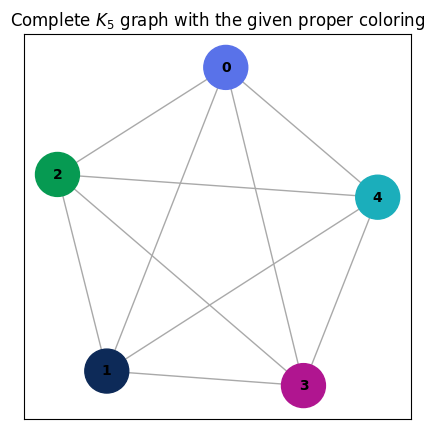

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(lbt_graph, with_labels=True, node_size=1000, node_color=lbt_coloring.values(), font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(fr"Complete $K_5$ graph with the given proper coloring")
plt.show()

At first glance, this may be a rather obvious result: in a complete graph, each node is connected to the other $n-1$ nodes, therefore the max degree is $n-1$. Since in a proper coloring, we cannot have the same color for two adjacent nodes, then it follows that each node $v$ must have $(n-1)$ different neighboring colors. Adding the distinct color we must use for node $v$, it follows that the smallest number of colors needed is $(n-1)+1 \equiv \max_v (\deg(v))+1$. Actually, we can extend the above theorem and say that: if $G$ is a loopless multigraph (not necessarily complete) and $\alpha$ is the maximum degree, then it has $G$ a $\alpha+1$ proper coloring (we are not saying that its chromatic number is $\alpha+1$!). The method coded above is actually an empirical prove of this statement - and it basically follows the skecthed proof of the Little Brooks Theorem given by D. Grindberg, see *References*. Indeed, at each step we are assignig color to each node, picking from a list of colors different from colors already assigned to its neighbors. Since $v_i$ has at most $\max_v(\deg(v))= \alpha$ neighbors, we have at most $\alpha$ colors to avoid. However, we have started from a list of $\alpha+1$ colors in total, so we always have one color left and we never run out of colors! Such $\alpha+1$ coloring is generally known as **greedy coloring** - since it basically applies a *greedy* decision at each step.

Let's make an example with a non-complete graph:

In [42]:
lbt_graph2 = nx.MultiGraph()
lbt_graph2.add_nodes_from([1, 2, 3, 4, 5, 6])
lbt_graph2.add_edges_from([(1, 2), (2, 3), (3, 4), (3, 5), (3, 1), (1, 6), (3, 6)])

[0, 0, 0, 0, 0, 0, 0]

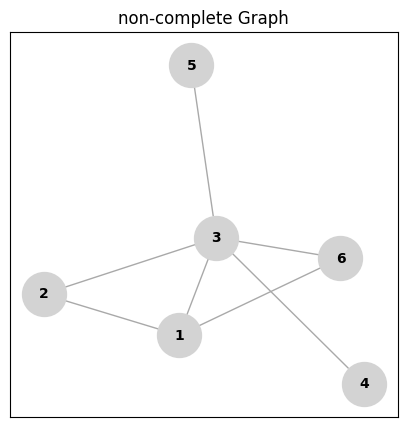

In [43]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(lbt_graph2, with_labels=True, node_size=1000, node_color="lightgrey", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"non-complete Graph")
plt.show()

In [44]:
# Getting the max degree
max_deg = max([lbt_graph2.degree(v) for v in lbt_graph2.nodes()])
print(f"The maximum degree of the given graph is: {max_deg}")

The maximum degree of the given graph is: 5


In [45]:
# Generate a number of colors equal to max_deg+1
available_colors2 = generate_random_colors(max_deg+1)
print(f"The number of available colors is {max_deg} + 1 =  {len(available_colors2)}")

The number of available colors is 5 + 1 =  6


In [46]:
lbt2_coloring = greedy_coloring(lbt_graph2, available_colors2)

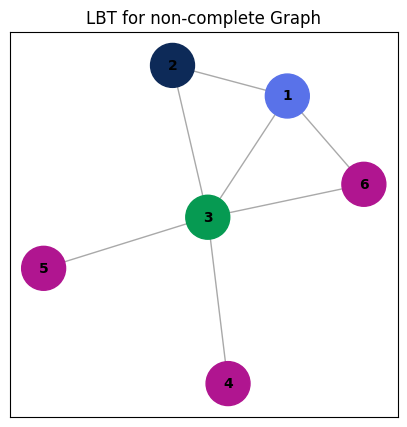

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(lbt_graph2, with_labels=True, node_size=1000, node_color=lbt2_coloring.values(), font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"LBT for non-complete Graph")
plt.show()

In [48]:
# Check how many distinct colors were used
num_used_colors = len(set(lbt2_coloring.values()))
print(f"Number of colors used: {num_used_colors}")
print(f"Initial color list size: {len(available_colors2)}")

Number of colors used: 4
Initial color list size: 6


Notice that in the above example we have found $4$-proper coloring of $G$. Of course, if $G$ has a $k$-proper coloring than it also has a $j$-proper coloring with $j > k$. Since the maximum degree of nodes in $G$ is 5, then $G$ will have a 6-proper coloring, given by assigning a distinct color to each node. We can formulate a strongest version of the Little Brooks Theorem, which is way more harder to prove and thus we omit here:

**Theorem (Brooks)**: Let $G=(V, E, \varphi)$ be a connected multigraph of maximum degree $\alpha$. Then the **chromatic number** $\chi(G) \leq \alpha+1$, where equality holds *if and only* if $G$ is a complete graph or an odd cycle.

`networkx` provide a method for coloring a graph using greedy graph coloring. The method is called `nx.coloring.greedy_color`. Its main parameter is the so-called `strategy`. Such parameter allows specifying a coloring strategy to use. For instance:

In [49]:
G_c3 = nx.cycle_graph(3)

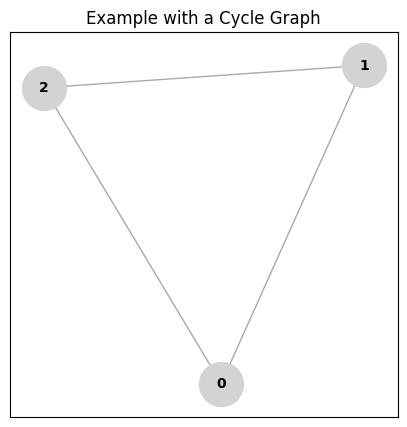

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(G_c3, with_labels=True, node_size=1000, node_color="lightgrey", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"Example with a Cycle Graph")
plt.show()

In [51]:
c3_gcoloring_rs = nx.coloring.greedy_color(G_c3, strategy="random_sequential")
c3_gcoloring_sl = nx.coloring.greedy_color(G_c3, strategy="smallest_last")

In [52]:
c3_gcoloring_rs, c3_gcoloring_sl

({2: 0, 1: 1, 0: 2}, {2: 0, 1: 1, 0: 2})

For example, with the `random_sequential` strategy, the order in which nodes are returned (and therefore the assigned colors) is random (the color assignment itself is of course not random but sequential, as we can see from the above integer numbers). Instead, with the `smallest_last` strategy, nodes are returned from the largest to the smallest one.

### The chromatic polynomial

We now introduce another central topic in graph coloring theory: the **chromatic polynomial of a graph**. While there is extensive literature on this subject, we will cover only the basics here. Interested readers can find references at the end of this notebook.

Let's first give an not "rigorous" definition. A chromatic polynomial $\chi(G, k)$ is a **<span style="color: red">function of $G$ and a variable $k$, defining the number of $x$-proper coloring of $G$ with $x\leq k$</span>**. In other words, it is the number of ways of proper coloring a graph $G$ with $k$ or fewer colors. Let's make an example. We consider the cycle graph $C_3$ sketched above. It is straighforward to see that this graph neither has a proper 1-coloring nor a 2-coloring. Instead, it has a trivial 3-proper coloring, obtained by assigning a distinct color to each node. How many coloring we can realize with three colors? By permuting the three distinct colors among the three vertices, we will get $3!= 6$ distinct colorings. Therefore, we could write the following function for $C_3$:
$$
\chi(C_3, k) = k(k-1)(k-2)
$$
This function is polynomial in the variable $k$, thus justying the name of **chromatic polynomial**. We shall prove in the following that $\chi$ is indeed always a polynomial in $k$. 

**Theorem (Deletion-Contraction)**: Let $G=(V, E, \varphi)$ be a multigraph. Let $G-e$ be the graph with the edge $e$ removed (a **deletion**) and $G/e$ the graph with edge $e$ removed and the nodes $uv=e$ contracted into a single vertex (a **contraction**). Then,
$$
\chi(G, k) = \chi(G-e, k) - \chi(G/e, k)
$$

We give here just an empirical evidence, using again the example of the cycle graph $C_3$. First of all, let's draw the graphs $C_3-e$ and $C_3/e$:

In [53]:
G_c3.nodes()

NodeView((0, 1, 2))

In [54]:
G_c3_e_deletion = nx.cycle_graph(3)
G_c3_e_deletion.remove_edge(0, 1)

In [55]:
# Contracting edge, avoiding self-loops formation
G_c3_e_contraction = nx.contracted_edge(G_c3, (0, 1), self_loops=False)

Text(0.5, 1.0, '$C_3/e$ graph')

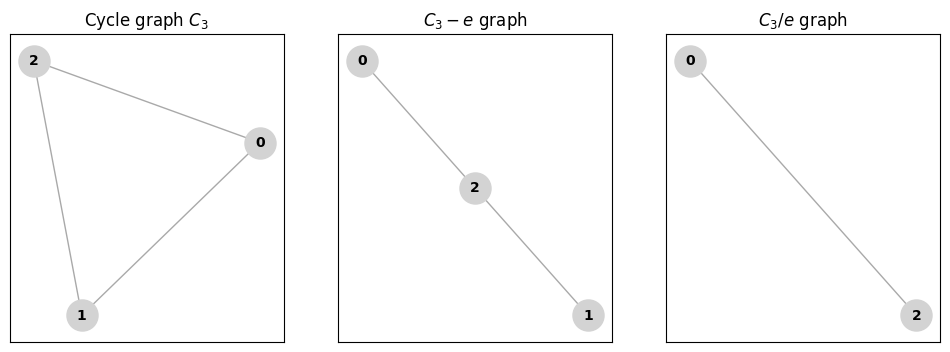

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

drawing_graphs = [G_c3, G_c3_e_deletion, G_c3_e_contraction]

for i, graph in enumerate(drawing_graphs):
    nx.draw_networkx(graph, 
                     node_size=500, node_color="lightgrey", 
                     font_size=10, font_weight='bold', 
                     edge_color='darkgrey', ax=ax[i]
    )
ax[0].set_title(f"Cycle graph $C_3$")
ax[1].set_title(f"$C_3-e$ graph")
ax[2].set_title(f"$C_3/e$ graph")

Let's consider the $C_3-e$ graph. Finding its chromatic polynomial is quite simple as for the original cycle graph:

- For vertex $0$, we can pick a color from the $k$ color available in case of $k$-coloring;
- For vertex $2$, we can pick a color from the remaining $k-1$ colors;
- For vertex $1$, we have still $k-1$ color available, since we could use again the first color assigned to $0$

Hence, the chromatic polynomial will be:
$$
\chi(C_e-e, k) = k(k-1)^2
$$
Indeed, for $k=2$, we have just 2 possibile proper coloring:

Text(0.5, 1.0, '$C_3-e$ graph')

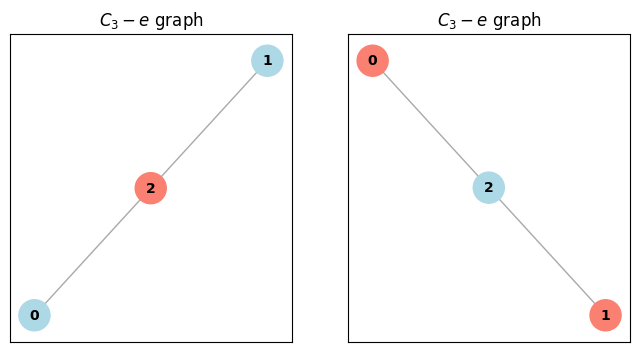

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

two_colorings_G_c3_e_contraction = [
    ["lightblue", "lightblue", "salmon"], 
    ["salmon", "salmon", "lightblue"]
]

for i, two_coloring in enumerate(two_colorings_G_c3_e_contraction):
    nx.draw_networkx(G_c3_e_deletion, 
                     node_size=500, node_color=two_coloring, 
                     font_size=10, font_weight='bold', 
                     edge_color='darkgrey', ax=ax[i]
    )
ax[0].set_title(f"$C_3-e$ graph")
ax[1].set_title(f"$C_3-e$ graph")

In case of 3 colors, we could realize $3(3-1)^2 = 12$ proper colorings. Indeed, for the first node we can choose among three possibile colors. For the second node, we can choose among 2 colors; for the remaining node we can choose again among 2 different colors, since this must just be different from the second one. Thus for each node, we have $2\times 2$ configuration, for a total of $3\times 4 = 12$ colorings. 

For $C_3/e$ graph, for the first node we have $k$ possibile choices; for the second node we have $k-1$ choices. Therefore, the chromatic polynomial will be:
$$
\chi(C_3/e, k) = k(k-1)
$$
Now, let us consider the expression of $\chi(C_3-e)$. We can rewrite it as follows:
$$
\begin{align}
\chi(C_3-e, k) &= k(k-1)^2 = k(k-1)(k-1) \\
&=k(k-1)k - k(k-1) =(k-2+2)(k-1)k-k(k-1)\\
&= (k-2)(k-1)k+2k(k-1)-k(k-1) = (k-2)k-1)k+k(k-1)
\end{align}
$$
Thus, 
$$
\chi(C_3-e, k) = \chi(C_3, k) + \chi(C_3/e, k)
$$
which rearranged gives the equation of the Contraction-Deletion theorem.

**Thereom**: The chromatic polynomial of the empty graph $G$ is $\chi(G, k) = k^n$ where $n$ is the number of nodes.

*Proof*. An empty graph is a graph with $n$ nodes and zero edges. Therefore, it consists of $n$ *connected components* of one node. For each color, we can pick a color among the $k$ available color indipendently, therefore:
$$
\chi(G, k) = \underbrace{k \cdot k \cdot k \cdot \cdots \cdot k}_{n \ \text{times}} = k^n
$$

<div style="border: 2px solid #ff8080; background-color: #ffe6e6; padding: 10px; border-radius: 5px; margin: 10px 0;">

**Theorem**
The chromatic polynomial of $G$, $\chi(G, k)$ is always a **polynomial function in $k$**
</div>

*Proof*. Let consider a graph with $n$ vertices and 0 edges. Then, we know that its chromatic polynomial is $k^n$. Now, by induction, let us assume that all graphs with fewer than $m$ edges has a chromatic polynomial which is a polynomial function of $k$. Let $G$ be a graph with $m$ edges. Then, by the Contraction-Deletion theorem we could write:
$$
\chi(G, k) = \chi(G-e, k) - \chi(G/e, k)
$$
$G-e$ has $m-1$ edges while $G/e$ has fewer than $m$ edges by definition, therefore their chromatic polynomials are polynomial functions in $k$. Since the chromatic polynomial of $G$ is obtained by subtracting the chromatic polynomial of $G-e$ and $G/e$, it follows that $\chi(G, k)$ is also a polynomial function in $k$. 

This theorem establishes a fundamental property of graphs: **<span style="color: red">no matter how complitcated is the topology and geometry of a graph, its chromatic polynomial will always be a polynomial function in one variable, $k$</span>**.

In the example given above, we were able to write an explicit expression for the chromatic polynomial through a simple inspection of the graph structure. However, calculating the chromatic polynomial is not usually this straightforward. Nevertheless, it is possible to derive explicit formulas for the chromatic polynomial, mainly thanks to the works of G. Birkhoff and H. Whitney in the early 20th century. In the following, we will present two of the most well-known formulas for expressing the chromatic polynomial, without providing formal proofs (see References). 

Before, stating these formulas, we need the following definition:

**Definition**: A **spanning subgraph** of a multigraph $G=(V, E, \varphi)$ is a multigraph of the form $H=(V, F, \varphi |_F)$, where $F$ is a subset of $E$. 

In other words, a spanning subgraph of $G$ is a multigraph obtained by removing some edges from $G$, without modifying the vertices. 

<div style="border: 2px solid #ff8080; background-color: #ffe6e6; padding: 10px; border-radius: 5px; margin: 10px 0;">
    
**Theorem (explicit formula)**
Let $G=(V, E, \varphi)$ be an undirected multigraph. Its chromatic polynomail $\chi(G, k)$ is given by:
$$
\chi(G, k) = \sum_{S\subseteq E}(-1)^{|S|}k^{c(G(S))}
$$

where $c(G)$ is the number of connected components of $G$, $G(S)$ is the spanning subgraph of $G$ with edge set $S$. 
</div>

In the above formula, the sum runs over "all possible subsets of $E$". Let us make an example, considering the following graph:

In [58]:
G_ef = nx.Graph()
G_ef.add_nodes_from([1, 2, 3, 4])
G_ef.add_edges_from([(1, 2), (1, 3), (1, 4)])

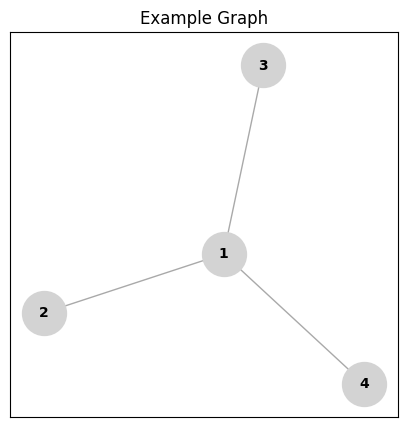

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(G_ef, with_labels=True, node_size=1000, node_color="lightgrey", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"Example Graph")
plt.show()

To apply the explicit formula, we need to list all possibile subsets of $E$. Look at the image below:
![Spanning-Subgraphs](../images/spanning-subgraphs-ex.png)

We have colored in red all possible subsets of $E$. The corresponding spanning subgraphs are obtained by removing the edge not colored in red. Therefore, for the first graph, removing the black edges leads to a graph with 4 disconnected vertices, i.e. 4 connected components. The number of edges is 0, therefore the first term of the chromatic polynomial will be $(-1)^0 k^4 = k^4$. For the second graph, removing black edges leads to a graph with three connected components. In this case, the number of edges in the spanning subgraph is 1, hence the corresponding term of the chromatic polynomial will be $(-1)^1k^3 = -k^3$. Then, applying these arguments to the remaining terms, we get:
$$
\begin{align}
\chi(G, k) &= k^4 + (-1)^1k^3 + (-1)^1k^3 + (-1)^1k^3 + \\
&+ (-1)^2k^2 + (-1)^2k^2 + (-1)^2k^2 + (-1)^3k^1 \\
&= k^4 - 3k^3 -3k^2 -k
\end{align}
$$

`networkx` shines again and allows easily computing the chromatic polynomial of a graph with a simple function call, `nx.chromatic_polynomial`:

In [60]:
# Printing the chromatic polynomial of a graph
nx.chromatic_polynomial(G_ef)

x**4 - 3*x**3 + 3*x**2 - x

For the sake of completeness, we report also another formulation of the chromatic polynomial formula, which arises from the previously states *Deletion-Contraction Theorem*.

<div style="border: 2px solid #ff8080; background-color: #ffe6e6; padding: 10px; border-radius: 5px; margin: 10px 0;">
    
**Fundamental Reduction Theorem**
Let $G=(V, E, \varphi)$ be an undirected multigraph. Its chromatic polynomail $\chi(G, k)$ is given by:
$$
\chi(G, k) = \begin{cases}
k^{n(G)} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{if} \ e(G)=0 \\
\chi(G-e, k) - \chi(G/e, k) \ \ \text{otherwise}
\end{cases}
$$

where $n(G)$ is the number of nodes of $G$, $e(G)$ is the number of edges of $G$ and $G-e, G/e$ are the $e$-deleted and $e$-contracted graph respectively. Such expression is also known as the **chromatic recurrence**.
</div>

The above formula can be easily implemented in Python with a recursive approach:

In [61]:
def chromatic_recurrence(G):
    '''
    Function returning the chromatic polynomial of G as a string 
    '''
    # If G has no edges, returning k^n
    if len(G.edges) == 0:
        return f"k**{len(G.nodes())}"

    # if G has some edges:
    if len(G.edges) > 0:

        # Creating a copy of G for deletion
        G_deleted = nx.Graph(G)

        # Cycle over G edges:
        for e in G.edges():
            
            # Deleting edge to generate G-e
            G_deleted.remove_edge(e[0], e[1])
            # Create G/e by contraction of e
            G_contracted = nx.contracted_edge(G, e, self_loops=False)

            # Returning the recurrence formula
            return f"({chromatic_recurrence(G_deleted)}) - ({chromatic_recurrence(G_contracted)})"

In [62]:
G_ef_chromatic_poly_str = chromatic_recurrence(G_ef)

In [63]:
print(f"The chromatic polynomial of the given graph is: {G_ef_chromatic_poly_str}")

The chromatic polynomial of the given graph is: (((k**4) - (k**3)) - ((k**3) - (k**2))) - (((k**3) - (k**2)) - ((k**2) - (k**1)))


The provided function returns the chromatic polynomial as a string - hence we have the single powers of $k$. We can use the Python library `sympy` to *evaluate* the function to a given $k$. For instance, to compute the $\chi(G, 3)$, i.e. the number of proper coloring for graph $G$ (the one of the example above) with 3 or less colors:

In [64]:
def evaluate_chromatic_polynomial(chromatic_polynomial_expression: str, symbol: str,  value: int) -> float:
    '''
    Function to evaluate the chromatic polynomial 

    Args:
        chromatic_polynomial_expression (str): The chromatic polynomial as a string, compatible with sympy syntax
        symbol (str): the symbol used in the expression
        value (int): the value to which evaluate the polyomial

    Returns:
        \chi(G, k)
    '''
    
    k = symbols(symbol)
    
    # Convert string to a sympy expression and substitute the given symbol
    expr = sympify(chromatic_polynomial_expression)
    
    return expr.evalf(subs={k: value})

In [65]:
evaluate_chromatic_polynomial(G_ef_chromatic_poly_str, "k", 3)

24.0000000000000

At first glance, the theory of chromatic polynomials may seem like a purely theoretical mathematical exercise without any practical application. However, this is not the case. Computing and evaluating chromatic polynomials can be applied to various problems that can be modeled using graph theory. One notable example is the problem of frequency assignment in wireless networks.

To keep it simple, imagine we have four cell towers. If two towers are too close, their signals can interfere with each other. Therefore, engineers need to assign different frequencies to adjacent towers to minimize interference. This problem can be modeled within graph theory: towers represent nodes, and edges between nodes indicate potential interference between towers. The goal is to assign different frequencies to adjacent towers while minimizing the number of frequencies used. Let's consider the following cycle graph where nodes represent towers:

In [66]:
graph_towers = nx.cycle_graph(4)

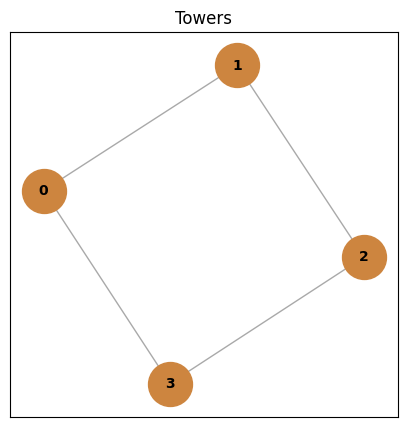

In [67]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(graph_towers, with_labels=True, node_size=1000, node_color="peru", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"Towers")
plt.show()

Computing the chromatic polynomial, we find:

In [68]:
graph_towers_chromatic_poly_str = chromatic_recurrence(graph_towers)

graph_towers_chromatic_poly_str

Evaluting the polynomial at different $k$, we get:

In [69]:
for i in range(1, 4):
    chi_i = evaluate_chromatic_polynomial(graph_towers_chromatic_poly_str, "k", i)
    print(f"The number of proper coloring with k<={i} is: {chi_i}")

The number of proper coloring with k<=1 is: 0E-124
The number of proper coloring with k<=2 is: 2.00000000000000
The number of proper coloring with k<=3 is: 18.0000000000000


Hence, two values are sufficient to assign different frequencies to each pair of adjacent towers and the number of proper coloring (i.e. frequency assignments) we can realize is 2 ( = the number resulting from evaluating the chromatic polynomial at $k=2$).

There a lot of other interesting results in graph coloring theorem - for instance we have not mentioned the so-called **four-color theorem**, which basically states that *no more than four colors are required to color the regions of any map so that no two adjacent regions have the same color* ([Wikipedia](https://en.wikipedia.org/wiki/Four_color_theorem)) - but this notebook does not pretend to be exhaustive about this topic. The interested reader can find some references at the end of this notebook. 

We end this section on graph coloring theory by showing the shape of chromatic polynomials of some of the main graph classes treated so far:

In [70]:
def path_graph_chi(n: int, k: float) -> float:
    '''
    Function evaluating the chromatic polynomial of a path graph: k*(k-1)^(n-1)
    '''
    return k*np.pow(k-1, n-1)
    
def complete_graph_chi(n: int, k: float) -> float:
    '''
    Function evaluating the chromatic polynomial of a complete graph: k*(k-1)(k-2)*...*(k-(n-1))
    '''
    chi_nk = 1
    i = 0
    while i != n:
        chi_nk *= k-i
        i += 1
    return chi_nk
    
def cycle_graph_chi(n: int, k: float) -> float:
    '''
    Function evaluating the chromatic polynomial of a cycle graph: (k-1)^n + (-1)^n * (k-1)
    '''
    return (k-1)**n + np.pow(-1, n)*(k-1)

def edgeless_graph_chi(n: int, k: float) -> float:
    '''
    Function evaluating the chromatic polynomial of an edgeless graph: k^n
    '''
    return np.pow(k, n)

In [71]:
# K values
k_values = np.arange(-2, 5, 0.1)

In [72]:
# Dictionary to collect data
graph_chi_data = {}

In [73]:
# Filling the Chi data
functions = {"path": path_graph_chi, 
             "complete": complete_graph_chi, 
             "cycle": cycle_graph_chi, 
             "edgless": edgeless_graph_chi
            }

n_values = 5
for n in range(2, n_values+1):
    graph_chi_data[n] = {key: [func(n, k) for k in k_values] for key, func in functions.items()}

In [74]:
graph_chi_data[2].keys()

dict_keys(['path', 'complete', 'cycle', 'edgless'])

In [75]:
# Arranging plots
n_cols = 2
n_rows  = math.ceil((n_values-1)  / n_cols) 

In [76]:
n_rows, n_cols

(2, 2)

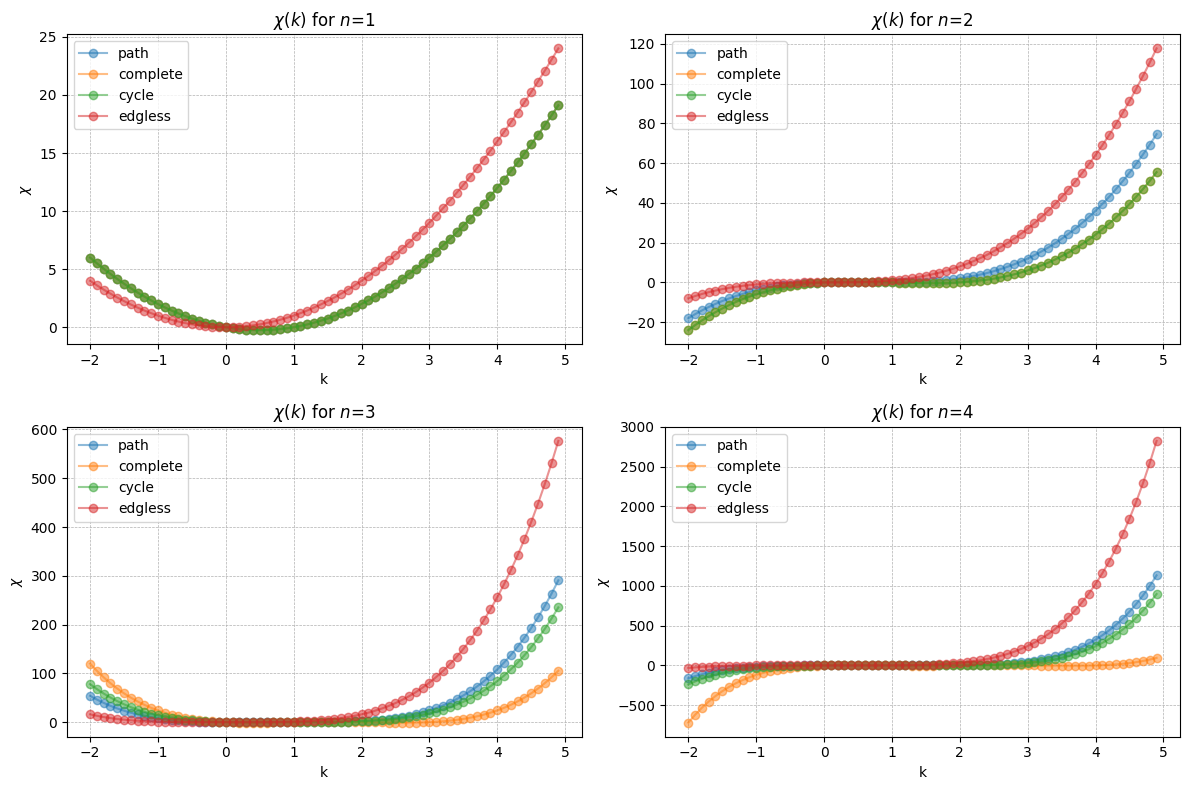

In [77]:
# Create the plot
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_rows*6, n_cols*4))

# Plot each series in the dictionary
ax = ax.flatten()
for i in range(n_values-1):
    for key, y_values in graph_chi_data[i+2].items():
        ax[i].plot(k_values, y_values, label=key, marker="o", alpha=.5)

    # Add labels, title, and legend
    ax[i].set_title(rf'$\chi(k)$ for $n$={i+1}')
    ax[i].set_xlabel('k')
    ax[i].set_ylabel(r'$\chi$')
    ax[i].legend()
    
    # Show grid for better readability
    ax[i].grid(True, linestyle='--', linewidth=0.5)
    
plt.tight_layout()

## An Introduction to Algebraic Graph Theory: the Adjacency Matrix

So far, we have considered graphs according to the 'classical' definition—that is, as a pair of sets: the vertex set and the edge set. However, graph theory can also be formulated within the framework of linear algebra. This approach arises from an equivalent definition of a graph in terms of a matrix, the so-called **adjacency matrix**. 

**Definition**: Let $G=(V, E)$ be a graph. The **adjacency matrix** $A(G)$ of $G$ is the matrix with the following matrix elements:
$$
A_{ij} = \begin{cases} 1 \ \text{if} \ v_i \ \text{and} \ v_j \ \text{are adjacent} \\
0 \ \text{otherwise}
\end{cases}
$$

For instance, let's consider a complete graph as the following:

In [78]:
# Complete graph
C3 = nx.complete_graph(3)

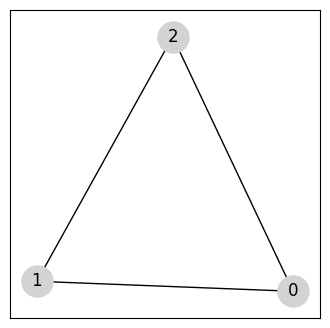

In [79]:
fig, ax = plt.subplots(figsize=(4, 4))

nx.draw_networkx(C3, node_size=500, node_color="lightgrey")

According to this definition, it naturally follows that the adjacency matrix will be an $n \times n $ matrix, where $n$ is the cardinality of the vertex set. Hence, for the given example, we have a $3\times 3$ matrix. Since, in a complete graph, each vertex is connected to the other by one edge, all matrix elements of $A(C_3)$ but the diagonal ones will be 1:
$$
A(C_3) = \begin{pmatrix} 0 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 0 
\end{pmatrix}
$$

Another example is the following *path graph*:

In [80]:
P4 = nx.path_graph(4)

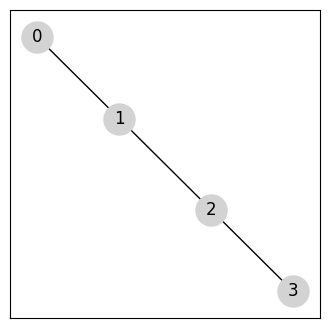

In [81]:
fig, ax = plt.subplots(figsize=(4, 4))

nx.draw_networkx(P4, node_size=500, node_color="lightgrey")

In this case:
- the first and the last row of the adjacency matrix we have one element equal to 1, corresponding to the adjacent vertex of the first and last vertex;
- the other rows have two elements equal to 1, namely those elements corresponding to the two vertices adjacent to the vertex given by the row index
$$
A(P_4) = \begin{pmatrix} 
0 & 1 & 0 & 0 \\
1 & 0 & 1 & 0 \\
0 & 1 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
$$

Of course, we could define an array in Python to represent the adjacency matrix, using `scipy` or `numpy` packages. However, `networkx` simplifies again this process, allowing you to convert a graph from the standard set representation to the matrix representation with a single function call: 

In [82]:
# Get the adjacency matrix of P4
P4_adj = nx.adjacency_matrix(P4)

In [83]:
P4_adj

<Compressed Sparse Row sparse array of dtype 'int64'
	with 6 stored elements and shape (4, 4)>

Notice that the resulting matrix is represented as a `scipy` **compressed sparse row sparse array**. Sparse array are arrays where most of the elements are 0. In this case, sparse row sparse array are used since most of the 0 elements are expected to occur along rows. Such `scipy` objects are used to efficiently handle matrix operations between sparse arrays, since just non-zero elements are stored in memory. To print the array and inspects the matrix elements we can convert the object to a standard `numpy` array:

In [84]:
print(P4_adj.toarray())

[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]


### The spectrum of a graph

One of the first concepts you may have encountered when studying linear algebra is that of the **spectrum** of a matrix, or more generally, the spectrum of a linear map. A **linear map** (or **linear transformation**), denoted as $L$, is a mapping between two vector spaces, $V \to W$, that preserves the fundamental operations of vector addition and scalar multiplication. In this sense, matrices can be naturally regarded as linear maps, since any $n \times m$ matrix $\boldsymbol{M}$ defines a linear transformation from $V = \mathbb{R}^n$ to $W = \mathbb{R}^m$, i.e.,  
$$
\boldsymbol{x} \in \mathbb{R}^n \mapsto \boldsymbol{M} \boldsymbol{x} \in \mathbb{R}^m.
$$

Given a linear map $L: V \to V$ (where for our purposes, we can take $V = \mathbb{R}^n$), the **spectrum** of $L$ is the set of its **eigenvalues** $\lambda$, which are the scalar values for which $L - \lambda I$ is not invertible. Geometrically, eigenvalues are associated with a special class of vectors known as **eigenvectors**. An eigenvector $\boldsymbol{v}$ of a matrix is a nonzero vector that is simply **scaled** by $\lambda$ when acted upon by the linear operator $L$, meaning it satisfies the following equation:

$$
\boldsymbol{L} \boldsymbol{v} = \lambda \boldsymbol{v} \quad \Rightarrow \quad (\boldsymbol{L} - \lambda \boldsymbol{I}) \boldsymbol{v} = 0.
$$

Eigenvalues are thus obtained by solving the characteristic equation:

$$
p(\lambda) = \det(\boldsymbol{L} - \lambda \boldsymbol{I}) = 0.
$$

Before discussing the meaning of the eigenvalues and eigenvectors of the adjcency matrix, let's show how to calculate them analytically. We consider the $C_3$ graph given above. We need to solve the following equation:
$$
\det \begin{pmatrix} -\lambda & 1 & 1 \\
1 & -\lambda & 1 \\
1 & 1 & -\lambda \end{pmatrix} = 0
$$
i.e.
$$
\begin{gather}
-\lambda ( \lambda^2 -1 ) - 1 (-\lambda -1 ) + (1 + \lambda) = 0 \\
-\lambda^3 + \lambda + \lambda + 1 + 1 + \lambda  = 0 \\
\lambda^3 - 3\lambda - 2 = 0
\end{gather}
$$
The reader can easily show that, applying the Ruffini's rule, the polynomial obtained above can be decomposed into the following product:
$$
\lambda^3 - 3\lambda - 2 = (\lambda^2 - \lambda - 2 )( \lambda +1 ) = 0
$$
Hence, the solutions of the characteristc equations are:
$$
\lambda_1 = -1 \ \ \ \lambda_2 = 2 
$$
where the first solution $\lambda_1 = -1$ has *multiplicity* 2, since we get this solution twice. 

We can verify such calculation by computing the eigenvalues using the `np.linalg.eig` method provided by the `numpy` package:

In [85]:
# Eigenvalues, eigenvectors of C3
C3_adj = nx.adjacency_matrix(C3)

C3_eigenvalues, C3_eigenvectors = np.linalg.eig(C3_adj.toarray())

In [86]:
C3_eigenvalues

array([-1.,  2., -1.])

**Preposition**: The coefficients of the charactestic polynomial $p(\lambda)$ of the adjacency matrix $\boldsymbol{A}$ associated to the graph $G=(V, E)$
$$
p(\lambda) = (-1)^n\lambda^n + c_1 \lambda^{n-1} + c_2 \lambda^{n-2} + \ldots + c_n
$$
satisfy:
- $c_1 = 0$
- $-c_2 = |E|$
- $-c_3$ is twice the number of triangles in $G$

To prove this preposition, we first remind (without proof) that the coefficients of the characteristic polynomial can be computed from the matrix *principal minors*, which are the determinant of the submatrix $M$ obtained by selecting just some rows and the corresponding columns. In particular, the coefficient $c_i$ of the characteristic polynomial is the sum of all principal minors of $\boldsymbol{A}$ with $i$ rows and columns. 

*Proof.* Let's consider the quantity $(-1)^i c_i$:
- $c_1$ is the sum of all $1 \times 1$ principal minors of the adjacency matrix. A $1 \times 1$ principal minor is the determinant of a matrix of just a single element, i.e. it is the element itself. Since we need to select one row and the corresponding element, i.e. $A_{11}$ or $A_{22}$, when summing we get the **trace** of $A$, i.e. $tr(A) = \sum_i A_{ii}$. The adjacency matrix of a graph is **traceless** *by definition*, hence $c_1 = 0$ always holds.
- $c_2$ is the sum of all $2\times 2$ principal minors of $A$. The $2\times 2$ submatrices with non-zero entries that we can realize from the adjacency matrix must be of the form: $$
M = \begin{pmatrix}
0 & 1\\
1 & 0 
\end{pmatrix}$$
hence $\det(M) = -1 $. There is one such minor for each pair of adjacent vertices of $G$, hence $(-1)^2 \cdot c_2 = -1 \cdot |E|$.
- There are essentially three possibile non-trivial $3 \times 3$ minors: $$\begin{pmatrix} 0 & 1 & 0 \\ 1 & 0 & 0 \\ 0 & 0 & 0 \end{pmatrix}, \begin{pmatrix} 0 & 1 & 1 \\ 1 & 0 & 0 \\ 1 & 0 & 0 \end{pmatrix}, \begin{pmatrix} 0 & 1 & 1 \\ 1 & 0 & 1 \\ 1 & 1 & 0 \end{pmatrix}$$
The determinant of the first two matrix are identically zero, while the determinant of the last matrix is -2. Such submatrix essentially defines three mutually  adjacent vertices (see for instance the adjacency matrix of the complete graph $C_3$ depicted above) in $G$, i.e. a triangle. Therefore $-c_3/2$ is the *number of triangles* in $G$.

Applying these arguments to the characteristic polynomial of the complete graph $C_3$ considered above:
$$
p(\lambda) = \lambda^3 - 3\lambda - 2
$$
we see that:
$$
c_1 = 0, c_2=3, c_3 = 2
$$
That is, $c_2 = 3$, i.e. the number of edges of $C_3$. The number of triangles is $-c_3/2 = 1$ as expected.

These simple results have a rather profound implication: **<span style="color: red">the adjacency matrix, despite being a purely algebraic object, encodes geometric information about the graph.</span>**

Interesting results can be obtained by the study of the *powers* of the adjacency matrix. First of all, let define the the **adjacency algebra** $\mathcal{A}(G)$ of a graph $G$, the algebra of polynomials in the adjacency matrix $\boldsymbol{A}=\boldsymbol{A}(G)$. When we have defined the adjacency matrix, we have said that its matrix elements $A_{ij}$ are vanishing if two nodes $v_i$ and $v_j$ are not *adjacent*, while $A_{ij}=1$ if the two nodes are neighbors. Equivalently, we could say that $A_{ij}$ is not null and equal to 1 if there exists one walk of length 1 from $v_i$ to $v_j$. Let's consider the following graph:

In [87]:
g = nx.Graph()
g.add_nodes_from([1, 2, 3])
g.add_edges_from([(1, 2), (2, 3)])

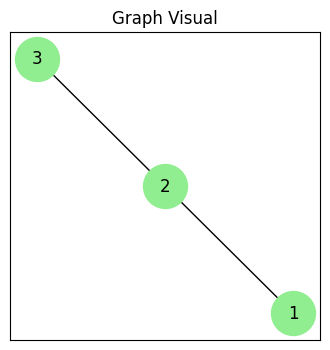

In [88]:
plot_simple_graph(
    g, 
    node_color="lightgreen",
    node_size=1000
)

Its adjacency matrix is the following:

In [89]:
# Get the adjacency matrix 
g_adj = nx.adjacency_matrix(g).toarray()
g_adj

array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]])

Let's compute $\boldsymbol{A}^2 = \boldsymbol{A}^T\boldsymbol{A}$:

In [90]:
# Computing the square of A
g_adj2 = np.matmul(g_adj.T, g_adj)

In [91]:
g_adj2

array([[1, 0, 1],
       [0, 2, 0],
       [1, 0, 1]])

Inspecting the matrix elements it's easy to verify that now the matrix entries represent the number of walks of length 2 between two nodes: e.g., $A^2_{11}=1$ because there is one walk of length 2 going from $v_1$ to $v_1$, namely $v_1v_2v_1$; $A^2_{22} = 2$ because there are two walks of length 2 going from $v_2$ to $v_2$, i.e. $v_2v_1v_2$ and $v_2v_3v_2$. This is just an heuristic proof, more generally one can show that:

**Lemma**: The number of walks of length $l$ in $G$ going from $v_i$ to $v_j$ is the entry position $(i, j)$ of the matrix $\boldsymbol{A}^l$. 


### The Laplacian matrix and the *algebraic connectivity*

There are a lot of interesting results that we could derive from the study of the adjacency matrix and the application of linear algebra, but a complete and in-depth discussion of algebraic graph theory is clearly beyond the scope of this notebook. Thus, here I have decided to discuss mainly one single concept that is however relevant in many fields where graph theory is applied, ranging from data science to quantum chemistry. This is the concept of **algebraic connectivity**. First of all, we need to introduce the following:

**Definition**: The **Laplacian matrix**, $\boldsymbol{L}$, of a simple graph $G$ is the matrix:
$$
\boldsymbol{L} = \boldsymbol{D}-\boldsymbol{A}
$$
where $\boldsymbol{A}$ is the adjacency matrix, while $\boldsymbol{D}$ is the **degree matrix**, i.e. a diagonal matrix whose elements are $D_{ii}=\deg({v_i})$.

As for the adjacency matrix, also the Laplacian matrix comes with a set of eigenvalues and eigenvectors and in particular, we can define:

**Definition**: The **algebraic connectivity**, $a(G)$ of a graph $G$ is the second smallest eigenvalue, $\mu_{n-1}$, of the laplacian spectrum.

From the above definition, it's not immediate to understand what the algebraic connectivity really means, but intuitively from the name we can expect it to be a measure of *how tightly connected is a graph*. Again, we will not prove why larger $\mu_2$ values means higher connectivity, but we will try to convince ourselves about this fact through different examples. Maybe not the most "mathematically rigorous" approach, but at least effective!

By merely looking at the edges connecting nodes, we may suppose that *complete graphs* are the most strongly connected graphs and therefore they should have high algebraic connectivities. For instance, let's take the following $K_3$ graph:

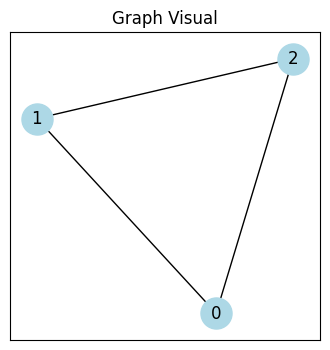

In [92]:
k3 = nx.complete_graph(3)
plot_simple_graph(k3, node_color="lightblue", node_size=500)

In [93]:
# Get the Laplacian matrix using NetWorkX
L_k3 = nx.laplacian_matrix(k3).toarray()

In [94]:
L_k3

array([[ 2, -1, -1],
       [-1,  2, -1],
       [-1, -1,  2]])

Notice the matrix elements of the Laplacian matrix: e.g. $L_{11}$ is 2, i.e. $D_{11} - A_{11} = 2 - 0 = 2$; instead $L_{12}$ is $D_{12}-A_{12} = 0 - 1 = -1$. Computing the eigenvalues:

In [95]:
L_k3_eigenvalues = np.linalg.eig(L_k3)
L_k3_eigenvalues.eigenvalues

array([ 3.0000000e+00, -5.3481844e-16,  3.0000000e+00])

In [96]:
L_k3_eigenvalues.eigenvectors

array([[ 0.81649658, -0.57735027,  0.24423262],
       [-0.40824829, -0.57735027, -0.79684797],
       [-0.40824829, -0.57735027,  0.55261536]])

We have three eigenvalues: $\{0^1, 3^2\}$, i.e. 0 with multiplicity 1 and 3 with multiplicity 2. Indeed, we can easily show that the laplacian spectrum of a complete graph is $\{0^1, n^{n-1}\}$, i.e. we always have an eigenvalue 0 with multiplicity 1 and the eigenvalue $n$ with multiplicity $n-1$. This is of course a consequence of the shape of the laplacian matrix. Indeed, for a complete graph, $\deg(v_i) = n-1$ and all nodes are connected with each other, hence $L$ can be written as:
$$
\begin{align}
\boldsymbol{L} = \boldsymbol{D}-\boldsymbol{A}  &= (n-1)\boldsymbol{I} - (\boldsymbol{J}-\boldsymbol{I}) \\
&= n\boldsymbol{I} - \boldsymbol{I} - \boldsymbol{J} +  \boldsymbol{I} \\
& = n\boldsymbol{I} -\boldsymbol{J}
\end{align}
$$
where $\boldsymbol{J}$ is the $n\times n$ matrix with all ones. Without a rigorous mathematical proof, we can indeed see that 0 is the eigenvalues corresponding to the eigenvector $\boldsymbol{u} = \boldsymbol{1} \in \mathbb{R}^n$ with elements $u_{ij}=1$:
$$
\boldsymbol{Lu} = (n\boldsymbol{I}-\boldsymbol{J}) = n\boldsymbol{u} - n \boldsymbol{u} = \boldsymbol{0}
$$
In the above eigenvector matrix, this is given by the column with elements -0.577 (the corresponding vectors are normalized!). The eigenvalue $n$ is instead associated to any vectors ortogonal to $\boldsymbol{1}$. Indeed, let $\boldsymbol{v}$ a vector such that $(\boldsymbol{1}, \boldsymbol{v})=0$ where $(,)$ denotes the dot product. Then, being $\boldsymbol{J}$ a matrix of all ones, it also follows $\boldsymbol{Jv}=0$, then acting with $\boldsymbol{L}$:
$$
\boldsymbol{Lv} = (n\boldsymbol{I}-\boldsymbol{J}) = n\boldsymbol{v}
$$
That is, every vector orthogonal to the identity vector is an eigenvector of $L$ with eigenvalue $n$. Since in a $n$-dimensional vector space, the space of all vectors ortogonal to $\boldsymbol{1}$ will be $(n-1)$ dimensional, it follows that the eigenvalue $n$ has multiplicity $n-1$. 

The second smallest eigenvalue of the complete graph $K_3$ is thus $3$. Let's see now that what happens to the laplacian spectrum as we remove an edge:

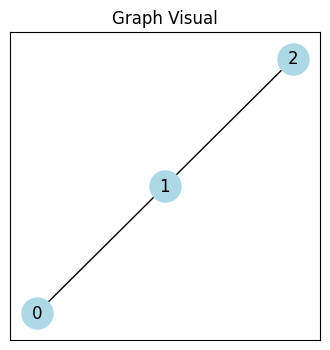

In [97]:
p3 = nx.path_graph(3)
plot_simple_graph(p3, node_color="lightblue", node_size=500)

In [99]:
# Get the Laplacian matrix using NetWorkX
L_p3 = nx.laplacian_matrix(p3).toarray()

In [100]:
L_p3_eigenvalues = np.linalg.eig(L_p3)
L_p3_eigenvalues.eigenvalues

array([ 3.000000e+00,  1.000000e+00, -6.172564e-17])

Notice that now the second smallest eigenvalue is $1$, which is smaller than the second smallest eigenvalue of the $K_3$ laplacian spectrum. To further convince ourself, let's consider an extreme case, i.e. that of a disconnected graph:

In [104]:
disc_g = nx.Graph()
disc_g.add_nodes_from(list(range(1, 4)))
disc_g.add_edges_from([(1, 2)])

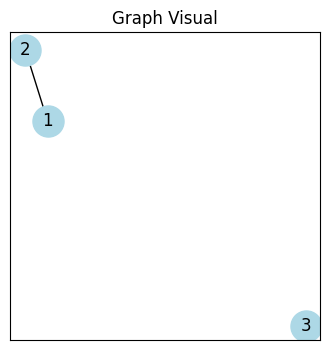

In [105]:
plot_simple_graph(disc_g, node_color="lightblue", node_size=500)

In [106]:
# Get the Laplacian matrix using NetWorkX
L_disc = nx.laplacian_matrix(disc_g).toarray()
L_disc

array([[ 1, -1,  0],
       [-1,  1,  0],
       [ 0,  0,  0]])

In case of a disconnected graph, the laplacian matrix has an interesting structure: it can always be written in a **block diagonal form**
$$
\boldsymbol{L} = \begin{pmatrix}
\boldsymbol{L}_1 & 0 & 0 & ... \\
... & \boldsymbol{L}_2 & 0 & ... \\
... & ... & ... & \boldsymbol{L}_n 
\end{pmatrix}
$$
where $L_i$ is the Laplacian matrix of the $i$-th connected component. For the example graph above, we have indeed:
$$
\boldsymbol{L}_1 = \begin{pmatrix} 1 & -1 \\
-1 & 1 \end{pmatrix} \ \ \ \boldsymbol{L}_2 = 0
$$
$L_1$ is a 2x2 matrix since the first connected components has 2 nodes, while the second component has just one node, hence $L_2 = 0$. Now, each Laplacian matrix has always a 0-eigenvalue, because each row sums to 0. Therefore, the constant vector $\boldsymbol{1}$ is always an eigenvector. If we have $n$ connected components, it means that we have at least $n$ 0-eigenvalues, hence the second smallest eigenvalue will necessarily be 0. Heuristically, we have shown that going from a totally disconnected graph to a fully connected graph, i.e. a complete graph, the value of $\mu_2$ has increased, thus justyfing the term of **algebraic connectivity**. 

This result makes $\mu_2$ a useful tool in graph connectivity analysis, with a lot of application in clustering, network theory and many other fields. 

## References

- *An introduction to graph theory*, Darij Grinberg, arXiv:2308.04512v2 (2024)
- [*NetworkX Tutorial*](https://networkx.org/documentation/stable/tutorial.html)

In [98]:
random.choice([1, 2, 3])

1